# A simple dynamic Malthusian model
___

> **Note:** Github numbers all equations when rendering $\LaTeX$ equations in markdown. For correct numbering please open the notebook in JupyterLab.

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets

# plot defaults
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = '16'

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

# Model description

Before the industrial revolution societies in general could not be explained by the Solow-Swan model. In 1798 Thomas Malthus noted his contemporary observations and formulated his theory. He argued that an increase in a nation's food production improved the well-being of the population, but only temporary since the better living standards led to population growth, which in turn restored the original per capita production. Thus long term per capita income stagnated and that is refered to as the "Malthusian trap". Empirical evidence suggests that the model is could be relevant dating back to at least 10.000 BC. In the subject "The history of economics" (Økonomisk historie) Malthus' theory is modelled. The total production is modelled as a Cobb-Douglas production that depends on the inputs labor $L_t$, level of techonology $A$ and land $X$.

\begin{align}
    Y_t &= L_t^{1-\alpha}\,(AX)^\alpha \, , \;\; 0<\alpha<1\\
\end{align}

Thus output per worker is $Y_t/L_t \equiv y_t$:
\begin{align}
    y_t &= \Big(\frac{AX}{L_t}\Big)^\alpha \label{eq1}\tag{1}
\end{align}

Furthermore the model assumes that the birth rate or surviving children per capita $n_t$ depends on the income with a factor $\eta$ (empirical evidence supports this assumption). Mere reproduction would imply $n_t = 1$. The factor $\eta$ captures the preferences and relative cost of having children. It is expected to be large in a society where there is a particular cultural valuation of having many children and/or where the cost of child rearing is modest.

\begin{align}
    n_t &= \eta y_t \label{eq2}\tag{2} \\
\end{align}

For simplification the model assumes that the entire population is working from birth to death. Equation 3 is the law of motion for population.
\begin{align}
    L_{t+1} &= n_t L_t + (1-\mu) L_t \label{eq3}\tag{3} \\
\end{align}

In the next period the population is given by the remaining population, those who did not die $(1-\mu) L_t$ (where $\mu$ is the death rate) and increased by total amount of surviving children each period $n_t L_t$.

# Solving steady state

## Analytically using sympy

To solve the model and find the steady state population $L^*$:
1. In [equation 2](#mjx-eqn-eq2) for $n_t$ substitute $y_t$ with the expression from [equation 1](#mjx-eqn-eq1).
2. Substitute this expression for $n_t$ into the law of motion in [equation 3](#mjx-eqn-eq3).
3. Set $L^* = L_{t+1} = L_t$ in steady state.
4. Solve for $L^*$ to find an expression for the steady state population.

We start by creating the sympy symbols and equation objects. For some symbols we add some assumptions that allows sympy to simplify the resulting equation as desired.

In [4]:
# declaring symbols
y_t = sm.symbols('y_t')
A = sm.symbols('A',real=True,positive=True) # A >= 0
X = sm.symbols('X',real=True,positive=True) # X >= 0
L_t = sm.symbols('L_t')
alpha = sm.symbols('alpha',real=True,positive=True) # strictly positive, since 0<alpha<1
n_t = sm.symbols('n_t')
eta = sm.symbols('eta',real=True,positive=True)
mu = sm.symbols('mu',real=True,positive=True)
L_t1 = sm.symbols('L_{t+1}')
L_star = sm.symbols('L^*')

In [5]:
# sympifying equations
eq1 = sm.Eq(y_t, (A*X)**alpha * L_t**(-alpha))
eq2 = sm.Eq(n_t, eta*y_t)
eq3 = sm.Eq(L_t1,(1-mu)*L_t + n_t*L_t)

___

**STEP 1:** Substituting [eq. (1)](#mjx-eqn-eq1) into [eq. (2)](#mjx-eqn-eq2):

In [6]:
# step 1
eq2_sub = eq2.subs(y_t, eq1.rhs)
display(eq2_sub)

Eq(n_t, L_t**(-alpha)*eta*(A*X)**alpha)

**STEP 2:** Substituting the new expression of [eq. (2)](#mjx-eqn-eq2) into [eq. (3)](#mjx-eqn-eq3) we get a new expression for the population law of motion:

In [7]:
# step 2
lom = eq3.subs(n_t, eq2_sub.rhs)
lom = sm.Eq(L_t1, lom.rhs.powsimp()) # only for aesthetics/readability when displaying
display(lom)

Eq(L_{t+1}, L_t*(1 - mu) + L_t**(1 - alpha)*eta*(A*X)**alpha)

> Note: For the part only for aesthetics - for some reason sm.simplify won't simplify the powers of this equation and .powsimp() cannot be called on Equality objects, but it does simplify powers as desired when using only the rhs (or lhs for that matter). Hence this rather confusing line.

**STEP 3:** Using the definition $L_{t+1} = L_t = L^*$

In [8]:
# step 3: substituting L* for L_t and L_t+1, by passing a list of tuples to sm.subs()
lom_ss = lom.subs([(L_t, L_star),(L_t1, L_star)])
display(lom_ss)

Eq(L^*, L^**(1 - mu) + L^***(1 - alpha)*eta*(A*X)**alpha)

**STEP 4:** Solving for steady state, $L^*$.

In [9]:
# step 4
ss = sm.Eq(L_star,sm.solve(lom_ss,L_star)[0]).expand().simplify() # expand -> simplify gives a cleaner result
display(ss)

Eq(L^*, A*X*(eta/mu)**(1/alpha))

A nice clean result for the steady state of population. We can quickly deduct that techonology $A$, land $X$ and child pref./cost $\eta$ affects long term population positively and death rate $\mu$ affects it negatively.

To compare with a numerical solution next, we will turn the steady state expression into a python function.

In [10]:
# steady state lambdified
ss_func = sm.lambdify(args = (A, X, alpha, eta, mu), expr = ss.rhs)

### Income per capita

In [11]:
# declaring symbol for ss income per capita
y_star = sm.symbols('y^*')

So how about the income per capita? Well if we insert the solution for $L^*$ into equation 1 we get can get an expression of steady state income per capita:

In [12]:
rhs = eq1.rhs.subs(L_t,ss.rhs).simplify()
sm.Eq(y_star, rhs)

Eq(y^*, mu/eta)

Which means that long term income per capita <u>**only**</u> depends on the death rate and preference/cost of having children. A rise in mortality $\uparrow\mu$ would increase the long term income per capita, and if more resources are spent on having children $\uparrow\eta$ the long term income would fall. This confirms the counterintuitive logic of the Malthusian model, where plagues, war and disorder increased material living standards, while peace, medicational improvements and insurance of harvest failures all decreased the material living standards in the long term by inducing population growth, that would "eat up" the total income due to the diminishing returns from the labor force growth on total output.
Thomas Malthus opposed the English poor laws, that was effectively wealth distribution, since they made the average man poorer in the long term. He also suggested reducing the birth rate by enforcing later marriages by law.

## Numerically

In the expression of law of motion for population [eq. (3)](#mjx-eqn-eq3) we can move $L_{t+1}$ to the right hand side and use $L_{t+1} = L_t = L^*$ for steady state, to set up a root finding problem:
$$0 = L^{*} (1 - \mu) + (L^{*})^{1 - \alpha} \eta (A X)^{\alpha} - L^{*}$$

Which can be solved numerically and the root found using `scipy.optimize.root_scalar`. The brent method is chosen since its considered the safest and usable for most functions. We start by chosing some parameters:

In [86]:
# define the values for our parameters
A_val = 3 # technology level
X_val = 8 # amount of land
alpha_val = 0.75
eta_val = 0.2 # child rearing preferences and relative cost
mu_val = 0.5 # half of the population passes away every period

In [87]:
# calling root_scalar
obj = lambda L: L*(1-mu_val)+L**(1-alpha_val)*eta_val*(A_val*X_val)**alpha_val-L
res  = optimize.root_scalar(obj,bracket=[0.1,100],method='brentq')
print(res)

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 7.073340477389544


In comparison with the analytical result:

In [15]:
print(f'analytical steady state: {ss_func(A_val,X_val,alpha_val,eta_val,mu_val):.3f}')
print(f' numerical steady state: {res.root:.3f}')

analytical steady state: 7.073
 numerical steady state: 7.073


# Graphic parameterization

In [16]:
# lambdifying the population law of motion to graph it
lom_func = sm.lambdify(args = (L_t, A, X, alpha, eta, mu), expr = lom.rhs)

In [17]:
widgets.interact(mp.graph_lom,
                 A_val = widgets.FloatSlider(description = '$A$' , min = 2, max = 10, step=1, value=3),
                 X_val = widgets.FloatSlider(description = '$X$' , min = 2, max = 10, step=1, value=8),
                 alpha_val = widgets.FloatSlider(description = r'$ \alpha $' , min = 0.35, max = 0.95, step=0.05, value=0.75),
                 eta_val = widgets.FloatSlider(description = '$\eta$' , min = 0.1, max = 2, step=0.1, value=0.2),
                 mu_val = widgets.FloatSlider(description = '$\mu$' , min = 0.1, max = 1, step=0.05, value=0.5),
                 initial_L = widgets.FloatSlider(description = 'initial', min=0.05, max=0.95, step=0.05, value=0.2),
                 ss_func = widgets.fixed(ss_func),
                 lom_func = widgets.fixed(lom_func));

interactive(children=(FloatSlider(value=3.0, description='$A$', max=10.0, min=2.0, step=1.0), FloatSlider(valu…

If we manipulate the parameters, we see that a higher productivity $A$, more land $X$ and higher birth preference/lower costs $\eta$ allows for a larger populations in the long term (the axis' ranges change in the graph), but they do nothing to the speed of convergence towards steady state. When moving $\alpha$ or $\mu$ the law of motion curve changes shape.

$\alpha$ denotes the degree of diminishing returns. If $\alpha$ is higher this means larger changes in income per capita for changes in population size (see [equation 1](#mjx-eqn-eq1)). Since fertility is proportional to income, this also means large change in surviving children each period (see [equation 2](#mjx-eqn-eq2)). The result is that population size changes quicker for high alpha and convergence towards steady state is faster.

A higher $\mu$ implies more people dying in every period. Lower average lifespan means fewer years where fertile women can give birth, which lowers the steady state population. But a higher $\mu$, more people dying in every period, also means larger population changes and thus larger income per capita changes in between each period.

Both $\alpha$ and $\mu$ change the speed of convergence towards steady steady, because they increase the malthusian grip. The dynamics of the model work quicker because the period to period changes are more severe.

# Implementing technological growth

So far we have assumed a constant level of technology $A$, while the technological advancement before the industrial revolution was low, it was not zero. Inventions such as the wheel, nails, paper, ships or plumbing are all well before the industrial revolution and must undeniably have improved productivity to some degree. To see the impact of a growing $A$ lets assume that:

\begin{align}
    \frac{A_{t+1}}{A_t}=g\label{eq4}\tag{4}\\
\end{align}

Where $g$ is the growth factor (so far we assumed that $g=1$).

Including technological change in the system we can define $l_t \equiv \frac{L_t}{A_t}$ as the relative population to technological level. To find the law of motion we can observe the following, by using the definition of the growth factor $g$ [eq. (4)](#mjx-eqn-eq4):

\begin{align}
    l_{t+1} g &= \frac{L_{t+1}}{A_{t+1}} \frac{A_{t+1}}{A_t} \\
    &\Leftrightarrow\\
    l_{t+1} g &= \frac{L_{t+1}}{A_t}\label{eq5}\tag{5}
\end{align}

As seen in equation 5 to find the new expression for the law of motion, we can simply divide [$L_{t+1}$ (eq. 3)](#mjx-eqn-eq3) with $A_t$ and isolate $l_{t+1}$. Steady state in the system including technological change would imply $l_{t+1}=l_t=l^*$.

## Analytical analysis of steady state

To solve the extended model and find the steady state of population relative to productivity $l^*$:
1. In [equation 2](#mjx-eqn-eq2) for $n_t$ substitute $y_t$ with the expression in [equation 1](#mjx-eqn-eq1).
2. Substitute this expression for $n_t$ into the law of motion in [equation 3](#mjx-eqn-eq3).
3. Divide law of motion [$L_{t+1}$ (eq. 3)](#mjx-eqn-eq3) with productivity $A_t$ to find $l_{t+1} g$.
4. Set $l^* = l_{t+1} = l_t$ in steady state.
5. Solve for $l^*$ to find an expression for the steady state.

In [56]:
# declaring symbols for the extended model
A_t = sm.symbols('A_t')
l_t = sm.symbols('l_t')
l_t1 = sm.symbols('l_{t+1}')
l_star = sm.symbols('l^*')
g = sm.symbols('g')


**STEP 3:** Since step 1 and 2 are the same as the previous model, we can start by dividing at step 3 (I did not have luck in trying to make sympy do this part in a readable manner, therefore done manually):

\begin{align}
    l_{t+1} g &= \frac{L_{t+1}}{A_t}\\
    &\Leftrightarrow\\
    l_{t+1} g &= \eta L_t^{1-\alpha} A_t^{-1} (A_t X)^\alpha + (1-\mu) \frac{L_t}{A_t}\\
    &\Leftrightarrow\\
    l_{t+1} g &= \eta L_t^{1-\alpha} A_t^{-(1-\alpha)} (X)^\alpha + (1-\mu) \frac{L_t}{A_t}\\
    &\Leftrightarrow\\
    l_{t+1} g &= \eta \bigg(\frac{L_t}{A_t}\bigg)^{1-\alpha} X^\alpha + (1-\mu) \frac{L_t}{A_t}\\
    &\Leftrightarrow\\
    l_{t+1} g &= \eta l_t^{1-\alpha} X^\alpha + (1-\mu) l_t\\
    &\Leftrightarrow\\
    l_{t+1} &= \eta g^{-1} l_t^{1-\alpha} X^\alpha + (1-\mu) g^{-1} l_t\\
\end{align}

In [57]:
# sympifying the new expression of the law of motion
lom2 = sm.Eq(l_t1, eta * g**-1 * l_t**(1-alpha) * X**alpha + (1-mu) * g**-1 * l_t)
display(lom2)

Eq(l_{t+1}, X**alpha*eta*l_t**(1 - alpha)/g + l_t*(1 - mu)/g)

**STEP 4:** Setting steady state, $l_{t+1}=l_t=l^*$.

In [58]:
# step4
lom2_ss = lom2.subs([(l_t1,l_star),(l_t,l_star)])
display(lom2_ss)

Eq(l^*, X**alpha*eta*l^***(1 - alpha)/g + l^**(1 - mu)/g)

**STEP 5:** Solving for steady state, $l^*$.

In [59]:
# step5: solving for ss
ss2 = sm.Eq(l_star, sm.solve(lom2_ss, l_star)[0].expand()).simplify()
display(ss2)

Eq(l^*, X*(eta/(g + mu - 1))**(1/alpha))

The steady state contains only constants over time. Population relative to productivity is constant in the long term, which implies that the numerator and denominator in the definition $l_t \equiv \frac{L_t}{A_t}$ grows at the same pace. Thus population also grows with the factor $g$.

In [60]:
# lambdifying to compare with numerical later
ss2_func = sm.lambdify(args=(g, X, alpha, eta, mu), expr=ss2.rhs)

### Income per capita

Keeping [equation (1)](#mjx-eqn-eq1) in mind we can rewrite the steady state equation from above to get an expression that is effectively equal to the per capita income in the steady state in this system with growing productivity $g>1$:

\begin{align}
    l^*=\Big(\frac{L}{A}\Big)^* &= X \bigg(\frac{\eta}{g+\mu-1}\bigg)^{1/\alpha}\\
    &\Leftrightarrow\\
    \Big(\frac{L}{A X}\Big)^* &= \bigg(\frac{\eta}{g+\mu-1}\bigg)^{1/\alpha}\\
    &\Leftrightarrow\\
    \bigg[\Big(\frac{L}{A X}\Big)^*\bigg]^\alpha &= \frac{\eta}{g+\mu-1}\\
    &\Leftrightarrow\\
    \bigg[\Big(\frac{A X}{L}\Big)^*\bigg]^\alpha &= \frac{g+\mu-1}{\eta}\\
    &\Leftrightarrow\\
    y^* &= \frac{g+\mu-1}{\eta}\\
\end{align}

Using sympy, we can achieve the same result, by substituting an expression for $L^*=l^*A^*$ into equation (1) as we did for the model without productivity growth.

In [78]:
# a. inserting the steady state for population L_star in eq1, which is ss2*A as stated above
ss_y = eq1.subs([(L_t,ss2.rhs*A), (y_t,y_star)]).simplify()

# b. telling sympy that denominator is positive and substituting it back and forth
denom = sm.symbols('d',real=True,positive=True)
ss_y = ss_y.subs(g+mu-1,denom).subs(denom,g+mu-1)

display(ss_y)

Eq(y^*, (g + mu - 1)/eta)

Since the expression consists of only constants, this means that steady state income is also stagnant when introducing technological growth. It is a higher steady state income $\frac{g+\mu-1}{\eta}>\frac{\mu}{\eta}$, but still stagnant.

> **Note:** The b. part above is rather messy, but I simply couldn't make it simplify the powers otherwise. It thinks that the denominator could be 0 and the entire function could evaluate to a complex number. If an interval for $g$ such as $g>1$ could be specified, it would not be a problem. Try to comment out these two lines and see the resulting expression.

## Numerical steady state

In the expression of law of motion found in STEP 4 above we can move $l_{t+1}$ to the right hand side and use $l_{t+1} = l_t = l^*$ for steady state, to set up a root finding problem:

In [79]:
sm.Eq(0,lom2_ss.rhs-l_star)

Eq(0, X**alpha*eta*l^***(1 - alpha)/g - l^* + l^**(1 - mu)/g)

Which can be solved numerically and the root found using `scipy.optimize.root_scalar`. The brent method is chosen since its considered the safest and usable for most functions. We use the parameters defined earlier and then add a value for the growth factor $g$ that is included in this model (set at 2% growth).

In [80]:
# parametrization
g_val = 1.02 # growth factor of productivity

In [81]:
# calling root_scalar
obj = lambda l_star: (X_val**alpha_val * eta_val * l_star**(1-alpha_val))/g_val - l_star + (l_star*(1-mu_val))/g_val
res = optimize.root_scalar(obj,bracket=[0.1,100],method='brentq')
print(res)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 2.237650164729664


In comparison with the analytical result:

In [82]:
print(f'analytical steady state: {ss2_func(g_val,X_val,alpha_val,eta_val,mu_val):.3f}')
print(f' numerical steady state: {res.root:.3f}')

analytical steady state: 2.238
 numerical steady state: 2.238


Same result yielded - we are satisfied with the solution. The nominal value cannot be compared to the solution from the simple model, since we solved for steady state population $L^*$ earlier and population relative to productivity in the extended model $l^*=\frac{L^*}{A^*}$.

$L_{t+1} &= n_t L_t + (1-\mu) L_t$

In [85]:
def f_cobb(L,X,A,alpha):
    return L**(1-alpha)*(X*A)**alpha

def f_ces(L,X,A,alpha,sigma):
    if sigma ==1:
        return f_cobb(L,X,A,alpha)
    
    else:
        return ((1-alpha)*L**((sigma-1)/sigma)+alpha*(A*X)**((sigma-1)/sigma) )**(sigma/(sigma-1))
    
    
def n(L,X,A,alpha,sigma,eta):
    y = f_ces(L,X,A,alpha,sigma)/L
    return eta*y


def L_t1(L,X,A,alpha,sigma,eta,mu):
    return n(L,X,A,alpha,sigma,eta)*L+(1-mu)*L


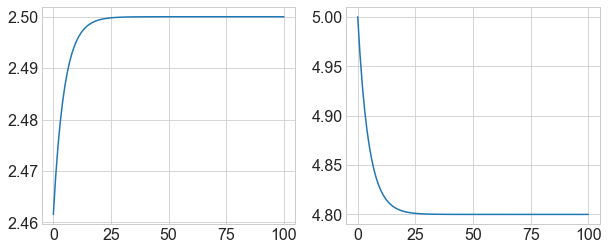

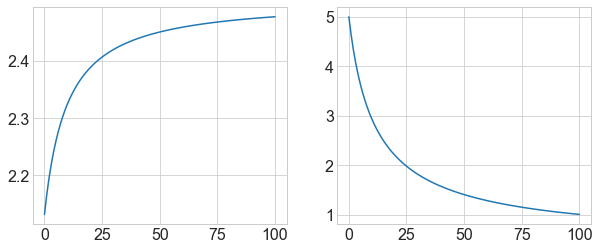

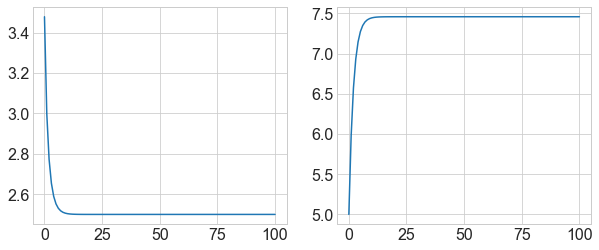

In [188]:
def simulate(L0,T,X_val,A_val,alpha_val,sigma_val,eta_val,mu_val):
    L_vec = [L0]
    y_vec = [f_ces(L_vec[0],X_val,A_val,alpha_val,sigma_val)/L_vec[0] ]



    for i in range(T):
        L_vec.append(L_t1(L_vec[-1],X_val,A_val,alpha_val,sigma_val,eta_val,mu_val))
        y_vec.append(f_ces(L_vec[-1],X_val,A_val,alpha_val,sigma_val)/L_vec[-1] )


    fig , ax = plt.subplots(ncols=2, figsize=(10,4))

    ax[0].plot(list(range(T+1)),y_vec)
    ax[1].plot(list(range(T+1)),L_vec)
    return L_vec, y_vec


L0 = 5
T=100
L_vec,y_vec = simulate(L0,T,X_val,A_val,alpha_val,sigma_val,eta_val,mu_val)
L_vec,y_vec = simulate(L0,T,X_val,A_val,alpha_val,0.4,eta_val,mu_val)
L_vec,y_vec = simulate(L0,T,X_val,A_val,alpha_val,1.5,eta_val,mu_val)

In [139]:
y_vec[-1]

2.4999999999999996

In [135]:
y_vec[-1]

2.5

# Conclusion

Malthus' growth theory is a rather pessimistic theory. In the long run there would be no increase in the standard of living, unless there were some limits on population growth. Looking at the analytical results (3.1.1) above we found that the long term income per capita in is constant and even when technological growth is introduced (5.1.1). Many papers have confirmed that the model is consistent with the empirical growth facts before 1800, when the production was mainly agricultural, population grew over time, but there were no significant improvements of the average standard of living. Empirical data also show that in some periods per capita income was high (for instance after the black death/the plague around 1350) but was always replaced by population growth in the long term.

![World economic history](https://rynotebook.files.wordpress.com/2014/03/clark1.png)

However Malthus' model failed to the sustained growth in standards of living in the richest countries around 1800. He was wrong on two accounts. 
- The model did not allow for the effect of an increase in capital on production. As in the Solow-Swan model capital reproducing itself is a large part of modern growth.
- He did not account for all the effects of economic forces on population growth. As an economy develops, the opportunity cost of raising a large family becomes bigger and the fertility rate drops.

When fertility is endogenous (ie. determined by the income per capita), it prevents technological growth to result in improvements in the long term standard of living. Setting fertility as an exogenous fixed variable changes this dynamic (just as we did deathrate in the model):
\begin{align}
    n_t &= \bar{n}
\end{align}
The population growth rate no longer depends on income:
\begin{align}
    L_{t+1} &= \bar{n}*L_t + (1-\mu)L_t \\
    &\Rightarrow \\
    \frac{L_{t+1}}{L_t} &= 1-\mu+\bar{n}
\end{align}

Looking at equation (1) again, we can derive that the growth rate in per capita income is ($A$ growth rate denoted as $g$):
\begin{align}
    y_t &= \Big(\frac{A_tX}{L_t}\Big)^\alpha \\
    &\Rightarrow \\
    \frac{y_{t+1}}{y_t} &= \Big( \frac{(A_{t+1}X)/L_{t+1}}{(A_t X)/L_t} \Big)^\alpha \\
    &\Leftrightarrow \\
    \frac{y_{t+1}}{y_t} &= \Big( \frac{A_{t+1}/A_{t}}{L_{t+1}/L_t} \Big)^\alpha \\
    &\Leftrightarrow \\
    \frac{y_{t+1}}{y_t} &= \Big( \frac{g}{1-\mu+\bar{n}} \Big)^\alpha
\end{align}

So if the numerator is larger than the denominator ie. $g > 1-\mu+\bar{n}$ sustained growth in per capita income is possible. It was likely this relationship between income and birthrate that he failed to describe with his model.